In [22]:
import json
import pandas as pd
import numpy as np
import os
import re
import time
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import datetime as dt


In [5]:
# Files to load
lstops_data_to_load = os.path.join("Data", "CTA_-_System_Information_-_List_of__L__Stops.csv")
ridership_data_to_load = os.path.join("Data", "CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv")

In [6]:
#load the data
l_stops_df = pd.read_csv(lstops_data_to_load)
ridership_data_df = pd.read_csv(ridership_data_to_load)

In [8]:
station_bools = l_stops_df[['MAP_ID','ADA','RED','BLUE','G','BRN','P','Pexp','Y','Pnk','O']].groupby('MAP_ID').any()
l_stops_df = l_stops_df.drop(['STOP_ID', 'DIRECTION_ID', 'STOP_NAME','ADA','RED','BLUE','G','BRN','P','Pexp','Y','Pnk','O'], axis=1).merge(station_bools, how='left', left_on='MAP_ID',right_index=True).drop_duplicates()

In [9]:
print(l_stops_df)

               STATION_NAME  \
0                      18th   
2               35th/Archer   
4      35th-Bronzeville-IIT   
6                      43rd   
8                      51st   
..                      ...   
287  Cermak-McCormick Place   
289                  Wilson   
290                 Addison   
292       Washington/Wabash   
298                 Ashland   

                              STATION_DESCRIPTIVE_NAME  MAP_ID  \
0                                     18th (Pink Line)   40830   
2                            35th/Archer (Orange Line)   40120   
4                    35th-Bronzeville-IIT (Green Line)   41120   
6                                    43rd (Green Line)   41270   
8                                    51st (Green Line)   40130   
..                                                 ...     ...   
287                Cermak-McCormick Place (Green Line)   41690   
289                        Wilson (Red & Purple Lines)   40540   
290                              

In [10]:
l_stops_df[['latitude','longitude']] =l_stops_df['Location'].str.replace('\(|\)','',regex=True).str.split(',',expand=True).apply(pd.to_numeric)

In [11]:
df = pd.merge(ridership_data_df, l_stops_df, how='left', left_on='station_id',right_on='MAP_ID')

In [12]:
df['south_side'] = df['latitude'] < 41.881
df[['south_side','rides']].groupby('south_side').mean()

,rides
south_side,
False,3709.676324
True,3006.989564


In [18]:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

station_id                           int64
stationname                         object
date                        datetime64[ns]
daytype                             object
rides                                int64
STATION_NAME                        object
STATION_DESCRIPTIVE_NAME            object
MAP_ID                             float64
Location                            object
ADA                                 object
RED                                 object
BLUE                                object
G                                   object
BRN                                 object
P                                   object
Pexp                                object
Y                                   object
Pnk                                 object
O                                   object
latitude                           float64
longitude                          float64
south_side                            bool
dtype: object

In [20]:
df['year'] = pd.DatetimeIndex(df['date']).year
df.head()

,station_id,stationname,date,daytype,rides,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,Location,ADA,...,BRN,P,Pexp,Y,Pnk,O,latitude,longitude,south_side,year
0,40850,Library,2004-10-09,A,1057,Harold Washington Library-State/Van Buren,Harold Washington Library-State/Van Buren (Bro...,40850.0,"(41.876862, -87.628196)",True,...,True,False,True,False,True,True,41.876862,-87.628196,True,2004
1,40780,Central Park,2010-06-18,W,1154,Central Park,Central Park (Pink Line),40780.0,"(41.853839, -87.714842)",True,...,False,False,False,False,True,False,41.853839,-87.714842,True,2010
2,41500,Montrose-Brown,2001-10-30,W,2116,Montrose,Montrose (Brown Line),41500.0,"(41.961756, -87.675047)",True,...,True,False,False,False,False,False,41.961756,-87.675047,False,2001
3,40500,Washington/State,2006-10-26,W,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2006
4,41090,Monroe/State,2010-07-07,W,9431,Monroe,Monroe (Red Line),41090.0,"(41.880745, -87.627696)",False,...,False,False,False,False,False,False,41.880745,-87.627696,True,2010


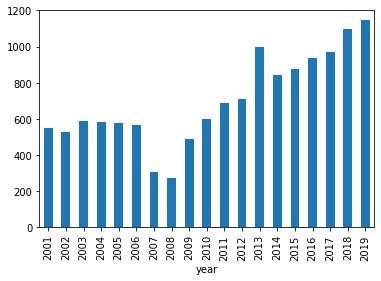

In [21]:
rides_by_sides = df[['year','south_side','rides']].groupby(['year','south_side']).mean().reset_index().pivot(index='year',columns='south_side',values='rides')
rides_by_sides.columns = ['north','south']
(rides_by_sides['north'] - rides_by_sides['south']).plot(kind='bar')

In [23]:
engine_all = create_engine("sqlite:///Census_Data.sqlite")